[region_grow_seg] итерация 1: добавлено пикселей = 104
[region_grow_seg] итерация 2: добавлено пикселей = 299
[region_grow_seg] итерация 3: добавлено пикселей = 479
[region_grow_seg] итерация 4: добавлено пикселей = 651
[region_grow_seg] итерация 5: добавлено пикселей = 887
[region_grow_seg] итерация 6: добавлено пикселей = 988
[region_grow_seg] итерация 7: добавлено пикселей = 1183
[region_grow_seg] итерация 8: добавлено пикселей = 1444
[region_grow_seg] итерация 9: добавлено пикселей = 1463
[region_grow_seg] итерация 10: добавлено пикселей = 1098
[region_grow_seg] итерация 11: добавлено пикселей = 1089
[region_grow_seg] итерация 12: добавлено пикселей = 1023
[region_grow_seg] итерация 13: добавлено пикселей = 1065
[region_grow_seg] итерация 14: добавлено пикселей = 860
[region_grow_seg] итерация 15: добавлено пикселей = 753
[region_grow_seg] итерация 16: добавлено пикселей = 707
[region_grow_seg] итерация 17: добавлено пикселей = 665
[region_grow_seg] итерация 18: добавлено пикселей 

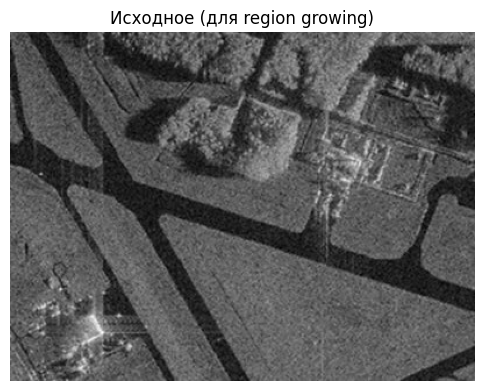

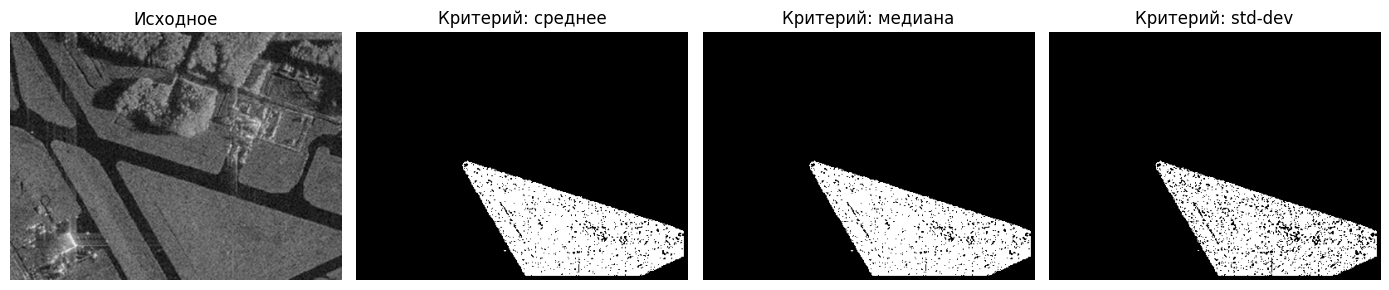


--- Сравнительная статистика (маска vs исход) ---
mean: SSIM = 0.0241; MSE = 10786.1460
median: SSIM = 0.0245; MSE = 10786.5412
std-dev: SSIM = 0.0143; MSE = 10639.5847


In [13]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity, mean_squared_error

src_img = cv2.imread('sar_1.jpg')
if src_img is None:
    raise FileNotFoundError("Файл 'sar_1.jpg' не найден в рабочей папке.")
gray_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6,6))
plt.imshow(gray_img, cmap='gray')
plt.title('Исходное (для region growing)')
plt.axis('off')

# Функции однородности (адаптированные имена) 

def homog_mean(image, region_mask, pt, T):
    """Критерий: абсолютная разница между средним по региону и значением в точке <= T"""
    region_vals = image[region_mask > 0]
    if region_vals.size == 0:
        return False
    avg = region_vals.sum() / region_vals.size
    return abs(float(avg) - float(image[pt])) <= T

def homog_median(image, region_mask, pt, T):
    """Критерий: медианная разница"""
    region_vals = image[region_mask > 0]
    if region_vals.size == 0:
        return False
    med = np.median(region_vals)
    return abs(float(med) - float(image[pt])) <= T

def homog_stddev(image, region_mask, pt, T):
    """Стандартное отклонение региона (включающие кандидата) меньше порога T."""
    region_vals = image[region_mask > 0]
    if region_vals.size == 0:
        return False
    std = np.std(region_vals)
    mean = np.mean(region_vals)
    return (std <= T) and (abs(float(image[pt]) - mean) <= 2 * std if std > 0 else abs(float(image[pt]) - mean) <= T)

#Универсальная функция разрастания
def region_grow_seg(image, seed_point, homog_func, neigh_radius, T):
    """
    image: single-channel (gray)
    seed_point: (row, col)
    homog_func: функция (image, mask, point, T) -> bool
    neigh_radius: радиус окна для определения соседства (r)
    T: параметр порога для критерия
    """
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    added = 1
    iteration = 0
    while added > 0:
        iteration += 1
        added = 0
        new_pixels = np.zeros(image.shape, np.uint8)
        for i in range(neigh_radius, image.shape[0] - neigh_radius):
            for j in range(neigh_radius, image.shape[1] - neigh_radius):
                if mask[i, j] == 0:
                    if mask[i - neigh_radius:i + neigh_radius + 1, j - neigh_radius:j + neigh_radius + 1].sum() > 0:
                        if homog_func(image, mask, (i, j), T):
                            new_pixels[i, j] = 1
        added = np.count_nonzero(new_pixels)
        print(f"[region_grow_seg] итерация {iteration}: добавлено пикселей = {added}")
        mask = cv2.bitwise_or(mask, new_pixels)
    return (mask * 255).astype(np.uint8)

# Подобранные (рабочие) параметры
seed = (250, 250)   # (row, col) — старт в центре предполагаемого газона
r = 5               # соседство
T_mean = 15         # порог для критерия среднего
T_median = 15       # порог для медианного критерия
T_std = 10          # порог для std-dev критерия

# Выполняем разрастание тремя критериями
mask_mean = region_grow_seg(gray_img, seed, homog_mean, r, T_mean)
mask_median = region_grow_seg(gray_img, seed, homog_median, r, T_median)
mask_std = region_grow_seg(gray_img, seed, homog_stddev, r, T_std)

# Отображение результатов
plt.figure(figsize=(14,8))
plt.subplot(1,4,1); plt.imshow(gray_img, cmap='gray'); plt.title('Исходное'); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(mask_mean, cmap='gray'); plt.title('Критерий: среднее'); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(mask_median, cmap='gray'); plt.title('Критерий: медиана'); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(mask_std, cmap='gray'); plt.title('Критерий: std-dev'); plt.axis('off')
plt.tight_layout()
plt.show()

# Сравнение с помощью SSIM и MSE 
mask_mean_u = mask_mean
mask_median_u = mask_median
mask_std_u = mask_std

(ssim_mean, diff_mean) = structural_similarity(gray_img, mask_mean_u, full=True)
(ssim_median, diff_median) = structural_similarity(gray_img, mask_median_u, full=True)
(ssim_std, diff_std) = structural_similarity(gray_img, mask_std_u, full=True)

mse_mean = mean_squared_error(gray_img, mask_mean_u)
mse_median = mean_squared_error(gray_img, mask_median_u)
mse_std = mean_squared_error(gray_img, mask_std_u)

print("\n--- Сравнительная статистика (маска vs исход) ---")
print(f"mean: SSIM = {ssim_mean:.4f}; MSE = {mse_mean:.4f}")
print(f"median: SSIM = {ssim_median:.4f}; MSE = {mse_median:.4f}")
print(f"std-dev: SSIM = {ssim_std:.4f}; MSE = {mse_std:.4f}")




Примерное количество пальм (по watershed): 70


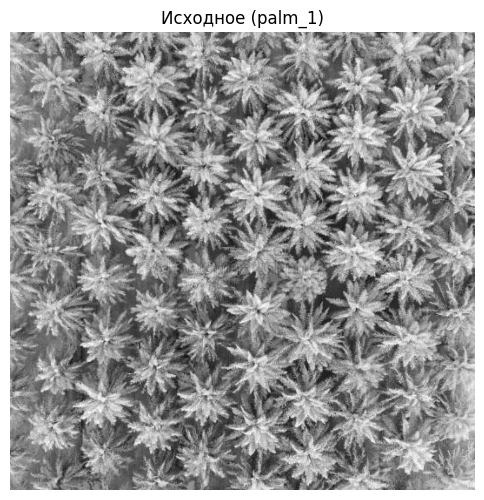

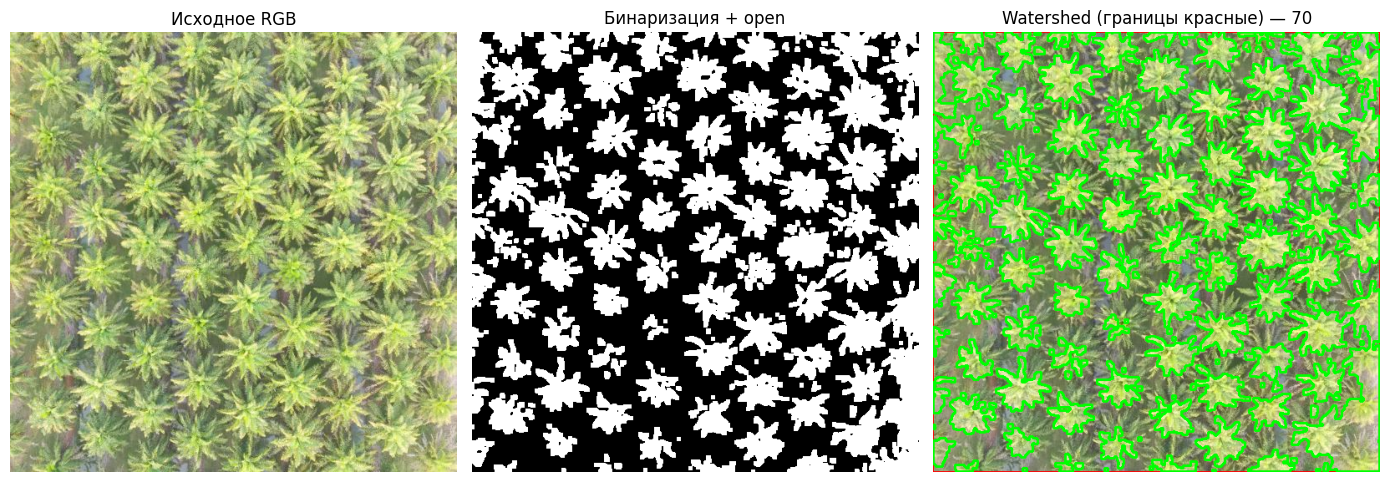

In [12]:

# Подсчёт пальм

palms_bgr = cv2.imread('palm_1.jpg')
if palms_bgr is None:
    palms_bgr = cv2.imread('palm_1.JPG')
if palms_bgr is None:
    raise FileNotFoundError("Файлы 'palm_1.jpg' или 'palm_1.JPG' не найдены в рабочей папке.")

palms_rgb = cv2.cvtColor(palms_bgr, cv2.COLOR_BGR2RGB)
palms_gray = cv2.cvtColor(palms_rgb, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(6,6))
plt.imshow(palms_gray, cmap='gray')
plt.title('Исходное (palm_1)')
plt.axis('off')

# Блюр для подавления шума
pal_blur = cv2.GaussianBlur(palms_gray, (5,5), 0)

# Бинаризация (Otsu)
ret, pal_thresh = cv2.threshold(pal_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Морфологическое очищение
kernel = np.ones((3,3), np.uint8)
pal_open = cv2.morphologyEx(pal_thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Distance transform и выделение точек-ядро
dist = cv2.distanceTransform(pal_open, cv2.DIST_L2, 5)
ret, pal_fg = cv2.threshold(dist, 0.37 * dist.max(), 255, cv2.THRESH_BINARY)
pal_fg = pal_fg.astype(np.uint8)

sure_bg = cv2.dilate(pal_open, kernel, iterations=3)

ret, markers = cv2.connectedComponents(pal_fg)
markers = markers + 1
markers[sure_bg == 0] = 0

# Применяем watershed
markers_ws = cv2.watershed(palms_rgb.copy(), markers)

# Количество объектов: уникальные маркеры, за исключением фона (1) и границ (-1)
unique_markers = np.unique(markers_ws)
# Считаем только маркеры >=2 (т.к. 1 — фон, 0 — неизвестно, -1 — границы)
num_trees = np.sum((unique_markers >= 2).astype(int))

print(f"\nПримерное количество пальм (по watershed): {num_trees}")

# Визуализация
vis = palms_rgb.copy()
vis[markers_ws == -1] = [255, 0, 0]  # границы красным
# контуры бинаризованных областей
contours, _ = cv2.findContours(pal_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(vis, contours, -1, (0,255,0), 2)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1); plt.imshow(palms_rgb); plt.title('Исходное RGB'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pal_open, cmap='gray'); plt.title('Бинаризация + open'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(vis); plt.title(f'Watershed (границы красные) — {num_trees}'); plt.axis('off')
plt.tight_layout()
plt.show()